# EDA - 1.0

## Imports

In [1]:
import pandas as pd
import numpy as np
from Utils import *

## Data Loading

In [2]:
data_folder = '..\\data\\raw\\'
series = "train_series.parquet"
events = "train_events.csv"

train_series = pd.read_parquet(data_folder+series)
train_events = pd.read_csv(data_folder+events)

In [3]:
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [4]:
memory_test = train_series[:10000]
print(memory_test.memory_usage(deep=True).sum() / (1024 * 1024))
print(memory_test.memory_usage(deep=True))
print('--------------------------')
print(memory_test.dtypes)

1.545074462890625
Index           128
series_id    690000
step          40000
timestamp    810000
anglez        40000
enmo          40000
dtype: int64
--------------------------
series_id     object
step          uint32
timestamp     object
anglez       float32
enmo         float32
dtype: object


In [5]:
# unique_series_ids = np.unique(train_series.series_id)

# train_id_map = pd.DataFrame({
#     "series_id": unique_series_ids,
#     "id_map": np.arange(len(unique_series_ids), dtype=np.uint16)
# })

# train_id_map.to_parquet("../data/train_id_map.parquet", index=False)

In [6]:
folder = '..\\data\\'
id_map = "train_id_map.parquet"

train_id_map = pd.read_parquet(folder+id_map)

In [7]:
# train_series = train_series.merge(train_id_map, on='series_id', how='left')

# train_series = train_series.drop(columns=['series_id'])

# train_series = train_series.rename(columns={'id_map': 'series_id'})
train_series = transform_and_rename_dataframe(train_series, train_id_map, 'series_id', ['series_id'], {'id_map': 'series_id'})

#train_series.timestamp = pd.to_datetime(train_series.timestamp) #waited for 40 minutes but it was still running

In [8]:
series_chunk = train_series[:100000]
series_chunk.timestamp[0]

'2018-08-14T15:30:00-0400'

In [9]:
memory_test_processed = train_series[:10000].copy()

# memory_test_processed.anglez = memory_test_processed.anglez.astype(np.float16)
# memory_test_processed.enmo = memory_test_processed.enmo.astype(np.float16)
memory_test_processed.timestamp = pd.to_datetime(memory_test_processed.timestamp)

# Check memory usage and data types
print(memory_test_processed.memory_usage(deep=True).sum() / (1024 * 1024))
print(memory_test_processed.memory_usage(deep=True))
print('--------------------------')
print(memory_test_processed.dtypes)

0.286102294921875
Index        80000
step         40000
timestamp    80000
anglez       40000
enmo         40000
series_id    20000
dtype: int64
--------------------------
step                                         uint32
timestamp    datetime64[ns, pytz.FixedOffset(-240)]
anglez                                      float32
enmo                                        float32
series_id                                    uint16
dtype: object


## Data Processing

### Duplicate/Null Values

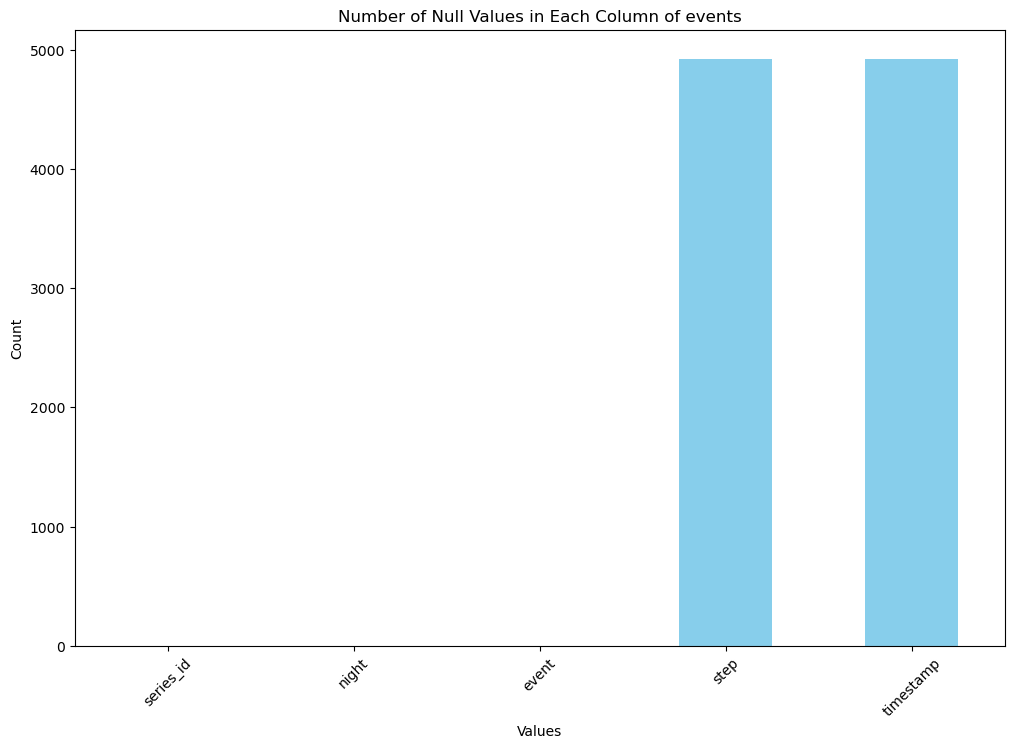

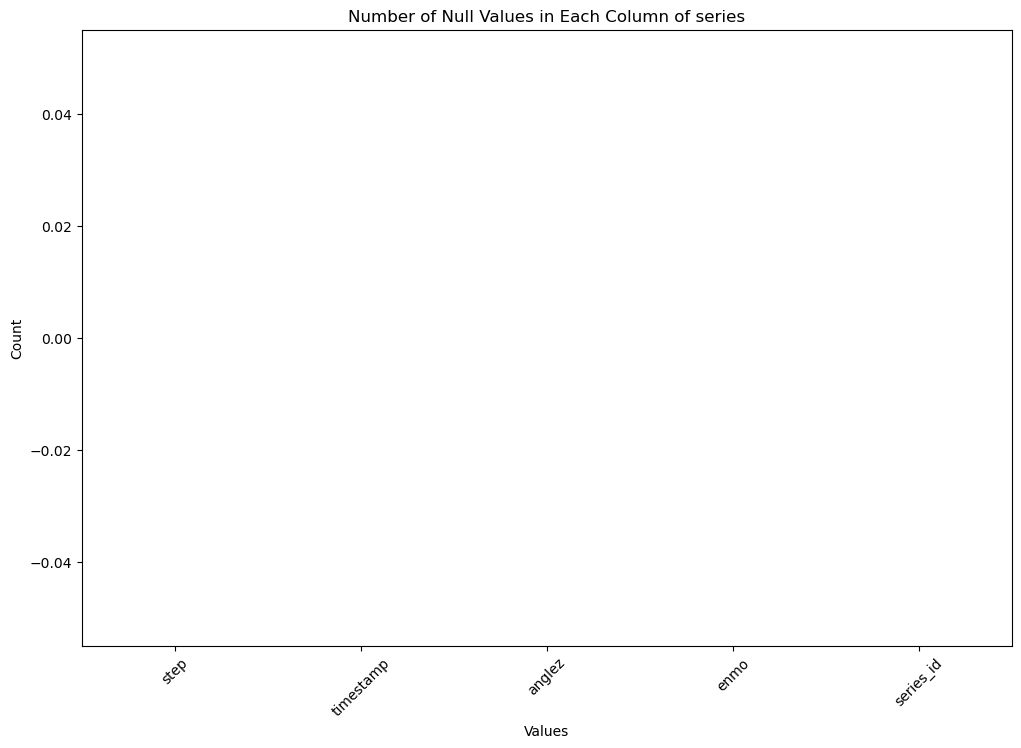

In [10]:
null_values = train_events.isnull()
null_counts = null_values.sum()
Title = "Number of Null Values in Each Column of events"
plot(null_counts,"bar",Title)

null_values = train_series.isnull()
null_counts = null_values.sum()
Title = "Number of Null Values in Each Column of series"
plot(null_counts,"bar",Title)

### Additional Features

In [11]:
series_chunk = clean_df(series_chunk)
train_events = clean_df(train_events)

c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\Utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['timestamp'].str.split('T', expand=True)[0]
c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\Utils.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\Utils.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [12]:
print(train_events.memory_usage(deep=True).sum() / (1024 * 1024))
print(train_events.memory_usage(deep=True))
print('--------------------------')
print(train_events.dtypes)

3.769376754760742
Index            128
series_id    1001052
night         116064
event         906750
step          116064
timestamp     116064
date          799731
time          780561
hour          116064
dtype: int64
--------------------------
series_id            object
night                 int64
event                object
step                float64
timestamp    datetime64[ns]
date                 object
time                 object
hour                float64
dtype: object


In [13]:
new_train_events = train_events.copy()

# train_id_map = pd.DataFrame({
#     "series_id": new_train_events.series_id.unique(),
#     "id_map": list(new_train_events.series_id.unique()).index
# })
# # train_id_map.id_map = train_id_map.id_map.astype(np.uint16)
# train_id_map.to_parquet("../data/train_id_map.parquet", index=False)

new_train_events.night = new_train_events.night.astype(np.uint16)
new_train_events.event = new_train_events.event.replace({'onset':'0', 'wakeup':'1'}).astype(np.uint8)
# new_train_events.step = new_train_events.step.astype(np.uint32)

In [14]:
# new_train_events = new_train_events.merge(train_id_map, on='series_id', how='left')
# new_train_events = new_train_events.drop(columns=['series_id'])
# new_train_events = new_train_events.rename(columns={'id_map': 'series_id'})
new_train_events = transform_and_rename_dataframe(new_train_events, train_id_map, 'series_id', ['series_id'], {'id_map': 'series_id'})


In [15]:
print(train_events.memory_usage(deep=True).sum() / (1024 * 1024))
print(train_events.memory_usage(deep=True))
print('--------------------------')
print(train_events.dtypes)

3.769376754760742
Index            128
series_id    1001052
night         116064
event         906750
step          116064
timestamp     116064
date          799731
time          780561
hour          116064
dtype: int64
--------------------------
series_id            object
night                 int64
event                object
step                float64
timestamp    datetime64[ns]
date                 object
time                 object
hour                float64
dtype: object


In [16]:
print(new_train_events.memory_usage(deep=True).sum() / (1024 * 1024))
print(new_train_events.memory_usage(deep=True))
print('--------------------------')
print(new_train_events.dtypes)

2.019012451171875
Index        116064
night         29016
event         14508
step         116064
timestamp    116064
date         799731
time         780561
hour         116064
series_id     29016
dtype: int64
--------------------------
night                uint16
event                 uint8
step                float64
timestamp    datetime64[ns]
date                 object
time                 object
hour                float64
series_id            uint16
dtype: object


In [123]:
train = pd.merge(series_chunk, new_train_events[["step", "event"]], on="step", how="left")

In [141]:
train.event = train.event.bfill(axis = "rows")
train.event = train.event.fillna(1)
train.event = train.event.astype(np.uint8)

In [143]:
train

,step,timestamp,anglez,enmo,series_id,date,time,hour,event
0,0,2018-08-14 15:30:00,2.636700,0.0217,0,2018-08-14,15:30:00,15,0
1,1,2018-08-14 15:30:05,2.636800,0.0215,0,2018-08-14,15:30:05,15,0
2,2,2018-08-14 15:30:10,2.637000,0.0216,0,2018-08-14,15:30:10,15,0
3,3,2018-08-14 15:30:15,2.636800,0.0213,0,2018-08-14,15:30:15,15,0
4,4,2018-08-14 15:30:20,2.636800,0.0215,0,2018-08-14,15:30:20,15,0
...,...,...,...,...,...,...,...,...,...
100659,99995,2018-08-20 10:22:55,47.771099,0.0057,0,2018-08-20,10:22:55,10,1
100660,99996,2018-08-20 10:23:00,48.725399,0.0003,0,2018-08-20,10:23:00,10,1
100661,99997,2018-08-20 10:23:05,48.909401,0.0000,0,2018-08-20,10:23:05,10,1
100662,99998,2018-08-20 10:23:10,48.777802,0.0001,0,2018-08-20,10:23:10,10,1


In [137]:
train_events.groupby("series_id").tail(1)["event"].unique()

array(['wakeup'], dtype=object)